<a href="https://colab.research.google.com/github/andresem/VaR-Opciones/blob/main/VaR_Opciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicación del artículo: *Métodos paramétricos de medición del Valor en Riesgo: apliación a opciones financieras sobre divisas*** 
### **Autores:**
* Diana Guzmán Aguilar
* Fredy Ocaris Pérez
* Carolina María Arboleda Arcila

### **Código:**
* Andrés Felipe Echavarría Molina
* Valentina García 

El objetivo de este código es aplicar la metodología planteada por los autores para calcualr el Valor en Riesgo de opciones europeas. <br>
Los datos utilizados son la TRM (*Tasa Representativa del Mercado*) del peso colombiano (COP) - dólar estadounidense (USD).

Para la valoración de las opciones los autores sugieren usar la siguiente formual: <br> <br>

# <center> $x = max\left [ S_{t} - K;0\right ]$ <br> <br>

Donde: $x$ es el valor intrínseco de la opción; $S_{t}$ corresponde al precio al cual se transa el activo subyacente en los mercados de valores en el momento t de la valoración; $K$ es el precio pactado para realizar la compra del activo subyacente determinado en la opción.

Por lo tanto si la opción tiene un valor negativo no se materializa y su valor intrínseco será $0$.

A continuación se define una función para obtener el valor de una opción.

In [ ]:
def ValorarOpcion(St, K):
  return max(St - K, 0)

Para medir la volatilidad de las opciones se sugiere el modelo **EWMA** ( *Exponentially Weighted Moving Average*) donde se le asigna un mayor peso a las observaciones más recientes. El modelo define la varianza condicional en el día $t$ mediante la siguiente ecuación: <br> <br>

# <center> $\sigma_{t} = \sqrt{\lambda \sigma_{t-1}^2 + (1-\lambda)r_{t-1}^2}$ <br> <br>

Donde, $\lambda$ es el factor de decaimento seleccionado mediante un proceso de optimización; $r^2$ es el cuadrado del rendimiento del día anterior; $\sigma^2$ es la varianza calculada para el día anterior; $t$ es el día en que se calcula la volatilidad. 

A continuación se define la función EWMA para calcular la volatilidad de un activo en un período $t$.

In [ ]:
'''Debido a que lambda es una palabra reservada en python, el factor de
decaimiento será llamado factorDec'''

from math import sqrt

def EWMA(factorDec, sigma, rendimiento):
  return sqrt(factorDec*(sigma**2) + (1 - factorDec)*(rendimiento**2))

Los datos historicos se pueden obtener la página web del Banco de la República de Colombia, en el artículo original los autores trabajaron con lo datos historicos de tres años desde el 1 de noviembre del 2012 hasta el 30 de octubre de 2015, un total de 733 datos (sin fines de semana ni días festivos).

Mounted at /content/drive


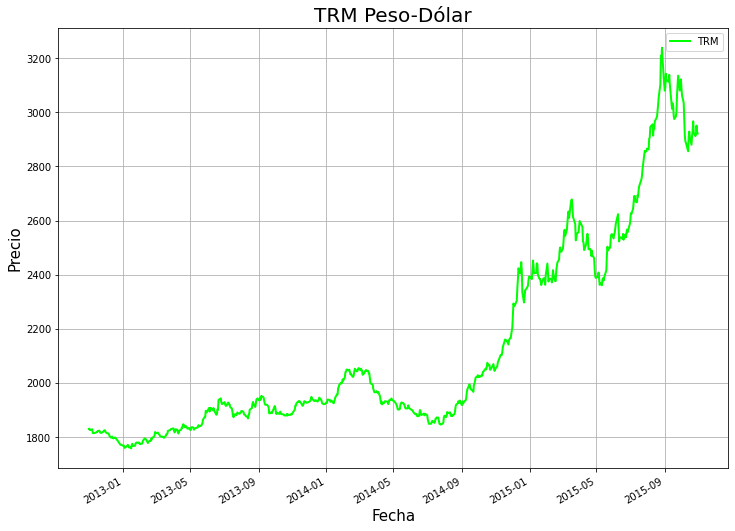

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

datosTRM = pd.read_excel('https://github.com/andresem/VaR-Opciones/raw/main/TRM_Historica.xlsx', index_col = 'Fecha')

datosTRM.plot(linewidth = 2, color = 'lime')
plt.title('TRM Peso-Dólar', fontsize = 20)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.grid()
plt.show()

Es necesario entonces obtener los retornos logaritmicos para esto usamos la siguiente formula: <br> <br>

# <center> $r_{t} = \ln{\cfrac{p_{t}}{p_{t-1}}}$<br> <br>

Donde $r$ es el retorno del período $t$, $p_{t}$ representa la TRM de un día $t$ y $p_{t-1}$ la TRM del día anterior. <br> <br>
Para esto se define la función retornoLog.

In [ ]:
from math import log

def retornoLog(precios):
  retornos = []
  for i in range(len(precios)):
    if i > 0:
      retornos.append(log(precios.values[i]/precios.values[i-1]))
    else:
      retornos.append(0)
  return pd.Series(retornos, index = precios.index)

Para visualizar el proceso podemos ir construyendo un DataFrame con los avances.

In [ ]:
datosResultado = datosTRM.copy()

Primero calculamos los retornos de la serie utilizando la función retornoLog y posteriormente lo añadimos al nuevo DataFrame llamado datosResultado

In [ ]:
retornos = retornoLog(datosTRM)


datosResultado['Retornos TRM'] = retornos
datosResultado = datosResultado.drop(datosResultado.index[0], 0)
datosResultado

,TRM,Retornos TRM
Fecha,,
2012-11-01,1831.25,0.000743
2012-11-02,1825.50,-0.003145
2012-11-06,1828.80,0.001806
2012-11-07,1814.99,-0.007580
2012-11-08,1814.83,-0.000088
...,...,...
2015-10-26,2912.08,-0.004550
2015-10-27,2918.21,0.002103
2015-10-28,2950.87,0.011130


El modelo se debe aplicar sobre los retornos, se debe implementar entonces una función que nos genere la semilla inicial la cual se consigue calculando la variación de la muestra y los pronósticos de la volatilidad, en este caso los retornos de la TRM para esto creamos dos funciones GenerarSemilla y PronosticarVolatilidad la cual usa la función EWMA para calcular la volatilidad del período $t$.

La varianza de la muestra se puede calcular con la siguiente fórmula aunque python cuenta con librerias que nos facilitan los cálculos.

#<center> $S^2 = \cfrac{\sum_{i=1}^{n}(X_{i}-\bar{X})^2}{n-1}$

In [ ]:
from statistics import variance
from math import sqrt

def GenerarSemilla(retornos):
  return variance(retornos)

def PronosticarVolatilidad(factorDec, retornos, semilla):
  pronostico = []

  for i in range(len(retornos)):
    if i > 0:
      pronostico.append(EWMA(factorDec, pronostico[-1], retornos[i-1]))
    else:
      pronostico.append(sqrt(semilla))

  return pd.Series(pronostico, index = retornos.index)

A continuación definimos la semilla y agregamos los resultados al DataFrame datosResultado.

In [ ]:
semilla = GenerarSemilla(datosResultado['Retornos TRM'])
print('La semilla cálculada es:', semilla)

pronosticoEWMA = PronosticarVolatilidad(0.95, datosResultado['Retornos TRM'], semilla)

datosResultado['Pronostico EWMA'] = pronosticoEWMA  
datosResultado


La semilla cálculada es: 4.382832675441271e-05


,TRM,Retornos TRM,Pronostico EWMA
Fecha,,,
2012-11-01,1831.25,0.000743,0.006620
2012-11-02,1825.50,-0.003145,0.006455
2012-11-06,1828.80,0.001806,0.006331
2012-11-07,1814.99,-0.007580,0.006183
2012-11-08,1814.83,-0.000088,0.006261
...,...,...,...
2015-10-26,2912.08,-0.004550,0.011804
2015-10-27,2918.21,0.002103,0.011550
2015-10-28,2950.87,0.011130,0.011267


A continuación se usaran ventanas moviles para calular el pronóstico real, para esto definimos una función llamada PronosticoMovil la cual recibe el número de ventanas a utilizar, habitualmente el número de ventanas usado es 21. La ventana móvil se calcula utilizando la fórmula de desviación estándar de la población.

# <center> $\sigma = \sqrt{\cfrac{1}{N}\sum^N_{i=1}{(x_{i} -\mu)^2}}$ </center>

In [ ]:
from statistics import pstdev

def PronosticoMovil(numeroVentanas, retornos):
  ventanMovil = []
  for i in range(len(retornos)):
    if i >= numeroVentanas:
      ventanMovil.append(pstdev(retornos[i-numeroVentanas:i]))
    else:
      ventanMovil.append(0)
  return pd.Series(ventanMovil, index = retornos.index)

Calculamos el pronóstico y lo agregamos al DataFrame de los resultados.

In [ ]:
pronosticoVM = PronosticoMovil(21, datosResultado['Retornos TRM'])
datosResultado['Pronostico VM'] = pronosticoVM
datosResultado

,TRM,Retornos TRM,Pronostico EWMA,Pronostico VM
Fecha,,,,
2012-11-01,1831.25,0.000743,0.006620,0.000000
2012-11-02,1825.50,-0.003145,0.006455,0.000000
2012-11-06,1828.80,0.001806,0.006331,0.000000
2012-11-07,1814.99,-0.007580,0.006183,0.000000
2012-11-08,1814.83,-0.000088,0.006261,0.000000
...,...,...,...,...
2015-10-26,2912.08,-0.004550,0.011804,0.011752
2015-10-27,2918.21,0.002103,0.011550,0.011385
2015-10-28,2950.87,0.011130,0.011267,0.010985


A continuación se hallará el error entre los pronósticos, para esto se define la función CalcularError, la función a hallar es el error cuadrático medio o por sus siglas en inglés RMSE.

#<center> $RMSE = \sqrt{\cfrac{1}{N}\sum_{t=1}^{N}(\sigma^2_{t, VM} - \hat{\sigma}^2_{t, EWMA})^2}$

In [ ]:
from math import sqrt

def CalcularError(real, prediccion):
  return sqrt(sum((real**2 - prediccion**2)**2)/len(prediccion))

Según el documento RiskMetric desarrollado por el JP Morgan el parametro $\lambda$ debe ser optimizado, para esto definimos una función llamada FuncionConjunta la cual nos retorna el $RMSE$ para un valor de $\lambda$ y ventana móvil dado, se buscará entonces el valor de $\lambda$ para el cual el $RMSE$ sea mínimo.

In [ ]:
def FuncionConjunta(factorDec, ventanaMovil, datos):

  volatilidadEWMA = PronosticarVolatilidad(factorDec, datos, GenerarSemilla(datos))
  volatilidadVM = PronosticoMovil(ventanaMovil, datos)
  
  return CalcularError(volatilidadEWMA[ventanaMovil:], volatilidadVM[ventanaMovil:])

Para minimzar el $RMSE$ utilizaremos la función minimize del módulo scipy, esta función nos permite optimizar el resultado de FuncioConjunta, y se modifican las columnas de DataFrame de resultados para incluir el modelo EWMA con el parametro $\lambda$ optimizado.

In [ ]:
from scipy.optimize import minimize

factorDec = minimize(FuncionConjunta, 0.95, (21, datosResultado['Retornos TRM']))
print('Valor de lambda:', factorDec.x[0])
print('RMSE:', factorDec.fun)

datosResultado['Pronostico EWMA'] = PronosticarVolatilidad(factorDec.x, datosResultado['Retornos TRM'], semilla)
datosResultado['Pronostico VM'] = PronosticoMovil(21, datosResultado['Retornos TRM'])

Valor de lambda: 0.9401353236011861
RMSE: 1.2548434275652845e-05


In [ ]:
datosResultado

,TRM,Retornos TRM,Pronostico EWMA,Pronostico VM
Fecha,,,,
2012-11-01,1831.25,0.000743,0.006620,0.000000
2012-11-02,1825.50,-0.003145,0.006422,0.000000
2012-11-06,1828.80,0.001806,0.006274,0.000000
2012-11-07,1814.99,-0.007580,0.006099,0.000000
2012-11-08,1814.83,-0.000088,0.006198,0.000000
...,...,...,...,...
2015-10-26,2912.08,-0.004550,0.011834,0.011752
2015-10-27,2918.21,0.002103,0.011528,0.011385
2015-10-28,2950.87,0.011130,0.011189,0.010985


Distribución de los retornos de la TRM, se asume que la distribución que siguen los retornos de la TRM es normal, cumpliendo así uno de los supuestos que plantea el modelo Black-Scholes, este es un supuesto puede no ajustarse muy bien a la realidad y puede ser un punto de mejora para los modelos de VaR en general.

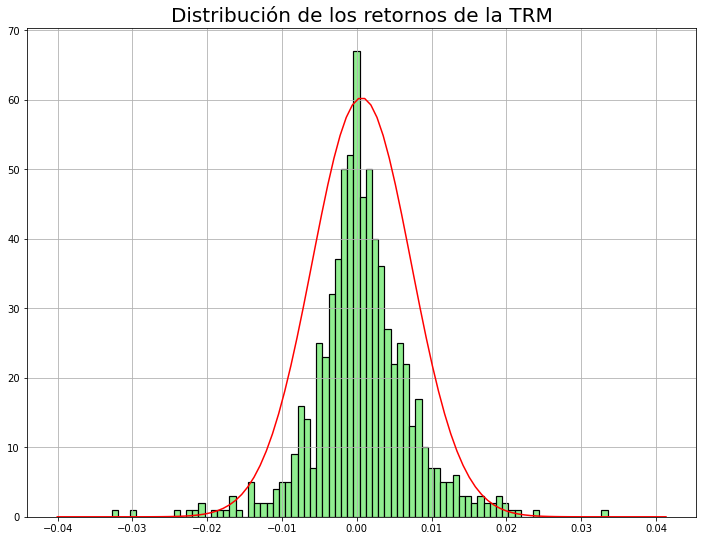

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math

plt.hist(datosResultado['Retornos TRM'], color = '#90EE90' ,bins = 80, edgecolor='black', linewidth=1.2)
plt.title('Distribución de los retornos de la TRM', fontsize = 20)

mu = datosResultado['Retornos TRM'].mean()
variance = datosResultado['Retornos TRM'].std()
sigma = math.sqrt(variance)
x = np.linspace(mu - 1/2*sigma, mu + 1/2* sigma, 100)
plt.plot(x, norm.pdf(x, mu, variance), color = 'red')

plt.grid()
plt.show()

Instalamos disfit para probar diferentes distribuciones y ver cuál es la que mejor se ajusta a los datos, en este caso una doble distribución Weibull.

In [ ]:
!pip install distfit

Mejor distribución: dweibull


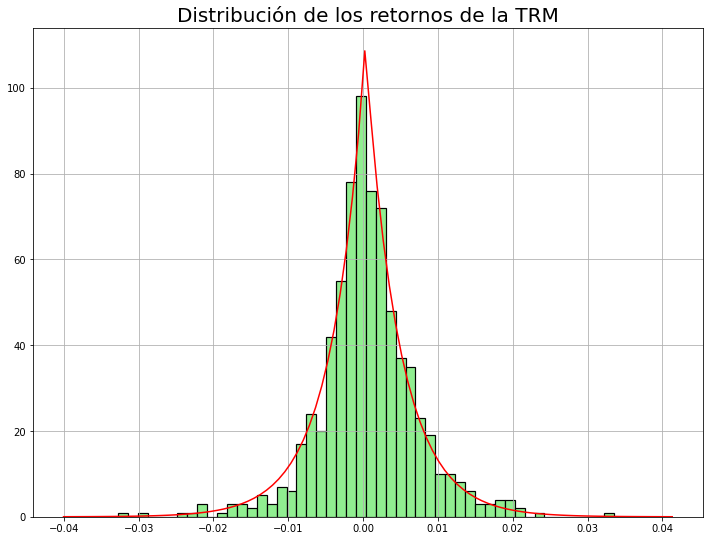

In [ ]:
from distfit import distfit
import numpy as np
from scipy.stats import dweibull

plt.hist(datosResultado['Retornos TRM'], color = '#90EE90' ,bins = 50, edgecolor='black', linewidth=1.2)
plt.title('Distribución de los retornos de la TRM', fontsize = 20)

dist = distfit(todf = True)
dist.fit_transform(datosResultado['Retornos TRM'], verbose = 0)
print('Mejor distribución:', dist.model['name'])

x = np.linspace(mu - 1/2*sigma, mu + 1/2* sigma, 100)

plt.plot(x, dweibull.pdf(x, *dist.model['params']), color = 'red')

plt.grid()
plt.show()


A continuación se muestran los gráficos de la volatilidad calculada usando el modelo EWMA

Mejor distribución: genextreme


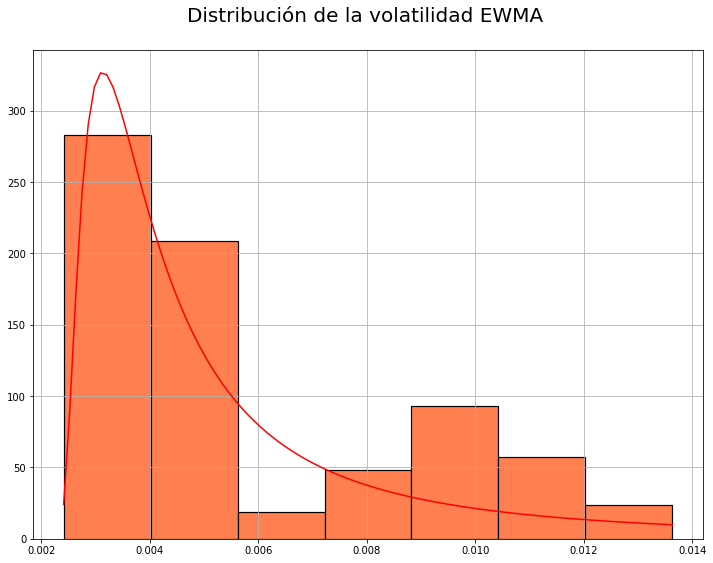

In [ ]:
from distfit import distfit
import numpy as np
from scipy.stats import genextreme

plt.hist(datosResultado['Pronostico EWMA'], bins = 7, color = '#FF7F50', edgecolor='black', linewidth=1.2)
plt.title('Distribución de la volatilidad EWMA \n', fontsize = 20)

distVol = distfit(todf = True)
distVol.fit_transform(datosResultado['Pronostico EWMA'], verbose = 0)
print('Mejor distribución:', distVol.model['name'])

x = np.linspace(min(datosResultado['Pronostico EWMA']), max(datosResultado['Pronostico EWMA']), 100)

plt.plot(x, genextreme.pdf(x, *distVol.model['params']), color = 'red')

plt.grid()
plt.show()

Mejor distribución: dweibull


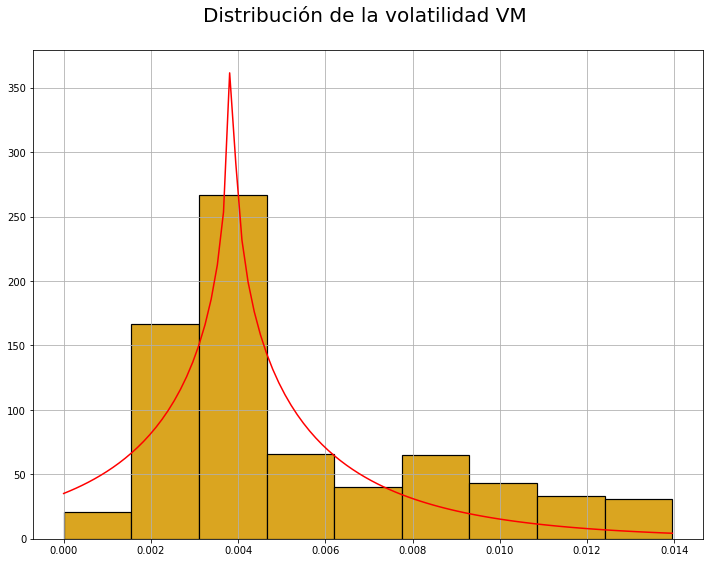

In [ ]:
from distfit import distfit
import numpy as np
from scipy.stats import dweibull

plt.hist(datosResultado['Pronostico VM'], bins = 9, color = '#DAA520', edgecolor='black', linewidth=1.2)
plt.title('Distribución de la volatilidad VM \n', fontsize = 20)

distVM = distfit(todf = True)
distVM.fit_transform(datosResultado['Pronostico VM'], verbose = 0)
print('Mejor distribución:', distVM.model['name'])

x = np.linspace(min(datosResultado['Pronostico VM']), max(datosResultado['Pronostico VM']), 100)

plt.plot(x, dweibull.pdf(x, *distVM.model['params']), color = 'red')

plt.grid()
plt.show()

Mejor distribución: dweibull


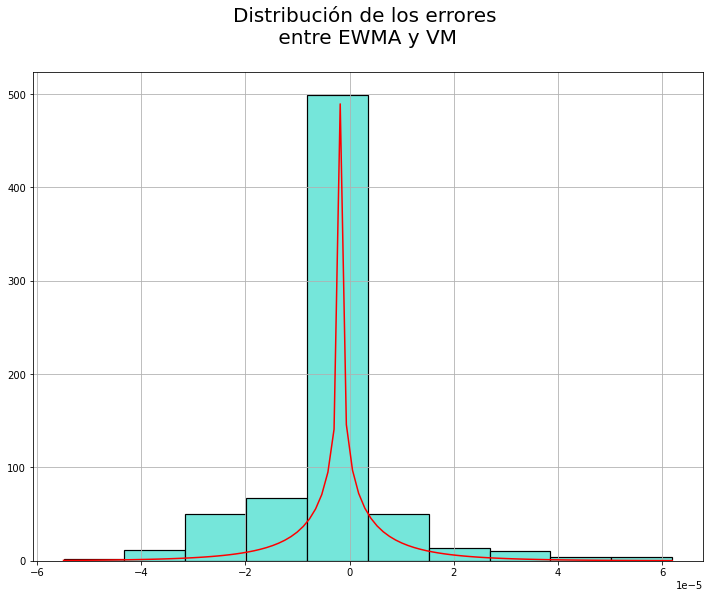

In [ ]:
from distfit import distfit
import numpy as np
from scipy.stats import dweibull

errores = datosResultado['Pronostico VM'][21:]**2 - datosResultado['Pronostico EWMA'][21:]**2

plt.hist(errores, color = '#75E6DA', 
         bins = 10,
         edgecolor='black', linewidth=1.2)
plt.title('Distribución de los errores \n entre EWMA y VM \n', fontsize = 20)

distErr = distfit(todf = True)
distErr.fit_transform(errores, verbose = 0)
print('Mejor distribución:', distErr.model['name'])

x = np.linspace(min(errores), max(errores), 100)
# 0.002 factor para escalar el gráfico
plt.plot(x, 0.002*dweibull.pdf(x, *distErr.model['params']), color = 'red')

plt.grid()
plt.show()

# ***Modelo de Black-Scholes (BS)***
El modelo BS es un método ampliamente utilizados para la valoración de opciones, el cual hace varios supuestos:

1. El precio del activo sigue un paseo aleatorio, esto significa que en períodos cortos de tiempo los cambios porcentuales en el precio siguen una distribución normal.
2. El modelo BS supone que el precio del activo subyacente se comporta como un movimiento browniano geométrico. 

Con estos supuestos se llegó a la conclusión de que todo activo que cumpla las anteriores condiciones debe satisfacer cierta ecuación diferencial, conocida como la ecuación Black-Scholes, la cual se basa en las siguientes hipótesis:
* El precio $S(t)$ del subyacente tienen una distribución lognormal, y además siguen una caminata aleatoria, asumiendo que en un período corto de tiempo sigue una distribución normal, con parámetros $\mu$ y $\sigma$ constantes.
* El precio del activo y el precio de la opción dependen de la misma fuente de incertidumbre.
* No se presentan costos de transacción, impuesto o pago de dividendos en el caso de las acciones. 
* No existen posibilidades de arbitraje libres de riesgo.
* Los inversionistas pueden prestar o pedir prestado al mismo interés libre de riesgo, $r$ cuyo valor es constante.
* El portafolio debe obtener una rentabilidad igual a la tasa libre de riesgo.



#  ***Modelo Garman-Kohlhagen***
Es un modelo analítico para valorar opciones europeas sobre monedas en el tipo de cambio spot, este modelo no sigue el mismo supuesto de Black-Scholes que indica que es posible endeudarse y otorgar préstamos a la misma tasa libre de riesgo. Ya que en el mercado de divisas, las tasas libres de riesgo son diferentes en cada país y el diferencial que se genera entre las afecta al tipo de cambio. El modelo Garma-Kohlhagen incluye ambos tipos de interés, la tasa de interés en la moneda nacional, y la tasa de interés de la moneda extranjera, como parte de las variables que afectan la valoración de una opción sobre divisas.<br>
La solución a la ecuación diferencial descrita es la siguiente:

# <center> $c = e^{-rt} \;\tilde{E} \;  max[S(t) - K; 0] = S_{0}e^{-r_{f}T}N(d_{1})-Ke^{-rT}N(d_{2})$ </center>

$d_{1}$ y $d_{2}$ están dados por:
# <center> $d_{1} = \cfrac{\ln{\cfrac{S_{0}}{K}} + (r - r_{f} + \cfrac{\sigma^2}{2})T}{\sigma \sqrt{T}}$ ; $d_{2} = \cfrac{\ln{\cfrac{S_{0}}{K}} + (r - r_{f} - \cfrac{\sigma^2}{2})T}{\sigma \sqrt{T}}$  </center>
Donde: 
* $c$ es el precio de la opción de compra, 
* $S_{0}$ el precio del actvio subyacente en la fecha de valoración,
* $K$ es el precio de ejercicio de la opción,
* $r$ es la tasa libre de riesgo local,
* $r_{f}$ es la tasa de libre de riesgo foranéa,
* $\sigma$ es el valor de la volatilidad de los rendimientos del activo subyacente, y
* $T$ es el plazo del vencimiento de la opción.
* $N()$ hace refencia a una distribución acumulada normal estándar.



En el siguiente bloque de código se definirán la solución de la ecuación diferencial estocástica con todos sus elementos, donde:
* s es igual a $S_{0}$
* rf es igual a $r_{f}$
* r es igual a $r$
* T es igual a $T$
* sigma es igual a $\sigma$
* k es igual a $K$
* norm.cdf() es igual a $N()$

In [ ]:
from scipy.stats import norm
from math import log, sqrt, e

def GarmanKohlhagen(s, rf, T, r, k, sigma):

  d1 = (log(s/k) + (r - rf + sigma**2/2)*T)/(sigma*sqrt(T))
  d2 = (log(s/k) + (r - rf - sigma**2/2)*T)/(sigma*sqrt(T)) 

  return  s*e**(-rf*T)*norm.cdf(d1) - k*e**(-r*T)*norm.cdf(d2)

# ***Condiciones de la opción***

|Opción de compra con subyacente divisa (dólar)|||
| --- | --- | --- |
| Cantidad de opciones | Cant | 100 |
| Nominal   USD      | N| 1000 |
| Precio de ejercicio en pesos | $ k $ | 2700.00 |
| Precio subyacente en pesos| $\ S_{0}$ | 2921.32 |
| Plazo de la opción | $ T $ | 1 año |
| Volatilidad anual | $ \sigma_{año} $ | 17.61% |
| Volatilidad diaria| $ \sigma_{1 día} $| 1.11% |
| Tasa libre de riesgo EA (COP)| $ r $ | 5.59% |
| Tasa libre de riesgo EA (USD) | $ \ r_{f} $ | 0.34% |


La tabla anterior muestra las condiciones de la opcion de compra obtenidas por los autores incluyendo el cálculo de la volatilidad, las cuales difieren un poco a las nuestras posiblemente por el proceso de minimización del factor $\lambda$
 
Para obtener el dato de la volatilidad diaria se utilizará el modelo EWMA definido anteriormente y para calcular la volatilidad anual se define una función llamada VolatilidadAnual, la cual recibe el último valor de la ventana móvil, y la cantidad de días bursatiles.

# <center> $\sigma_{1día} = \sqrt{\lambda \sigma_{t-1}^2 + (1-\lambda)r_{t-1}^2}$ 

# <center> $\sigma_{año} = \text{vm}_{t} \sqrt{252}$ </center>

se utilizan un calendario bursatil con 252 días.


In [ ]:
from math import sqrt

def VolatilidadPeriodo(vm, diasBursatiles):
  return vm*sqrt(diasBursatiles)

volatilidadDia = EWMA(factorDec.x, datosResultado['Pronostico EWMA'][-1], datosResultado['Retornos TRM'][-1])

volatilidadAnual = VolatilidadPeriodo(datosResultado['Pronostico VM'][-1], 252)

print('Volatilidad del próximo día: {} %'.format(round(volatilidadDia*100, 2)))
print('Volatilidad anual: {} %'.format(round(volatilidadAnual*100, 2)))

Volatilidad del próximo día: 1.07 %
Volatilidad anual: 17.25 %


El precio de la opción de compra utilizando la función denominada GarmanKohlhagen con las características determinadas anteriormente sería:

In [ ]:
precioOpcion = GarmanKohlhagen(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

print('El precio de la opción es:', round(precioOpcion, 2), 'pesos colombianos por cada dólar')

El precio de la opción es: 418.56 pesos colombianos por cada dólar


# ***Valor en Riesgo para derivados***

Los métodos utilizados para medir el valor en riesgo de los derivados brindan información acerca de la velocidad de cambio de los parámetros y su exactitud. La velocidad se convierte en un factor importante cuando se tiene exposición a diferentes factores de riesgos lo que implica un gran nú mero de correlaciones, como es el caso de las opciones, donde su valor se ve afectado por el cambio en el valor del subyacente, volatilidad implícita, tasa de interés o tiempo. Estas variables se manejan de forma más fácil con un enfoque que involucre las letras griegas, dados los componentes no lineales de las opciones.

***Letras griegas:***  Se utilizan para cuantificar las exposiciones que contienen las opciones a los factores de riesgo. Cada una mido como el precio de la opción debería responder a un cambio en alguna variable, ya sea el precio del subyacente, la volatilidad implícita, la tasa de interés o el plazo. Existen diversas variables externas que afectan el precio de una opción, cuyo efecto puede ser estudiado a través de las letras griegas, y que sirven,además, para establecer medidas de riesgo en los portafolios con opciones.

Las principales letras griegas se definen y calculan de la siguiente manera:

***Delta***: Se define como la variación que se presenta en el precio de la opción por una unidad de cambio en el precio del activo subyacente. Se conoce también como el coeficiente de cobertura, el cual indica el número de unidades del activo subyacente necesario para cubrir una posición en opciones. Se calcula a través de la derivada parcial del precio de la opción con relación al precio del activo subyacente. Utilizando la fórmula de valoración de Black-Scholes para una opción de compra

# <center> $ \delta = \cfrac{\partial_{c}}{\partial_{s}} = e^{-r_{f}T}N(d_{1})$ 


***Gamma***: Mide el efecto que la inestabilidad del mercado produce en el valor de Delta. Por lo tanto, el Gamma de una opción mide la tasa de cambio del Delta cuando el precio de la acción varía una uni dad. Matemáticamente se expresa como la segunda derivada del precio de la opción respecto a la variación en el precio del activo subyacente o la primera derivada de Delta. En el caso de una opción de compra.

#  <center> $ \gamma = \cfrac{\partial_{\delta}}{\partial_{S}} = \cfrac{\partial^2_{\delta}}{\partial_{S^2}}= e^{-r_{f}T} \cfrac{Z(d_1)}{S \sigma \sqrt{T}} $ 


Siendo $ Z(d_1) $ es el valor función de densidad de probabilidad de la distribución normal, Gamma es una medida de la sensibilidad de Delta si la última representa la velocidad de cambio, Gamma representa la aceleración de dicho cambio.

A continuación se definirán funciones para las letras griegas, las funciones serán llamadas Delta y Gamma, y los parametros de entrada serán los mencioandos en las fórmulas anteriores.

In [ ]:
from scipy.stats import norm
from math import log, sqrt, e

def Delta(s, rf, T, r, k, sigma):

  d1 = (log(s/k) + (r - rf + sigma**2/2)*T)/(sigma*sqrt(T))

  return e**(-rf*T)*norm.cdf(d1)

def Gamma(s, rf, T, r, k, sigma):

  d1 = (log(s/k) + (r - rf + sigma**2/2)*T)/(sigma*sqrt(T))

  return e**(rf*T)*norm.pdf(d1)/(s*sigma*sqrt(T))

In [ ]:
delta = Delta(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

gamma = Gamma(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

print('El valor de la letra griega Delta es:', round(delta, 3))
print('El valor de la letra griega Gamma es:', round(gamma, 4))

El valor de la letra griega Delta es: 0.799
El valor de la letra griega Gamma es: 0.0006


En el artículo, los autores proponen tres métodos para calcular el VaR, el primero de ellos es el ***VaR Delta-Gamma***, esta metodología establece que un cambio en el precio del derivado durante un período de tiempo determinado como consecuencia de la variación del precio del activo subyacente se puede aproximar por una función polinómica de segundo orden, cuyos coeficientes están dados por las sensibilidades principales de los derivados, como son Delta $(\delta)$ y Gamma $(\gamma)$
La aproximación Delta-Gamma requiere el cálculo de la derivada de segundo orden, además el Delta $(\delta)$ y la rentabilidad de cada instrumento se calculan de la siguiente ecuación:

#  <center> $ \Delta(P) = \delta * \Delta(S) + \cfrac{1}{2}*\gamma*\Delta(S^2)$ 

Donde: 
* $\Delta(P)$: representa el cambio en el valor del portafolio;
* $\Delta(S)$: representa el cambio en el valor del activo subyacente;
* Delta $(\delta)$: es la primera derivada del precio de la opción respecto al precio del activo subyacente;
* Gamma $(\gamma)$: es la derivada de segundo orden del instrumento con respecto al subyacente.

Bajo la hipótesis de que las variaciones del precio del activo subyacente siguen una distribución normal con media cero y desviación $\sigma$, se tendría que el valor crítico de $\Delta(S)$ (variación precio activo subyacente) estaría dado por la siguiente ecuación:

#  <center> $ \Delta(S^*) = Z_{\alpha}S\sigma\sqrt{T}$

Donde:

* $Z_{\alpha}$ corrsponde a la distribución percentil normal estándar.
* $\alpha$ hace refencía al nivel de confianza deseado.

Cuando se aplica este resultado para el cálculo del VaR en una posición larga en una opción de compra, donde el riesgo esté determinado por la caída del precio del activo subyacentem es decir cuando $\Delta(S^*)$ sea menor que cero, se tiene que la variación extrema del precio de la opción está dada por:

#  <center> $\Delta(V^*) = -\delta \Delta S^* + \cfrac{1}{2}\gamma(\Delta S^*)^2 = -\delta Z_{\alpha}S \sigma \sqrt{T} + \cfrac{1}{2}\gamma (Z_{\alpha}S \sigma T)^2$

Con la medición en valor abosulto del VaR, se tendría la ecuación:

#  <center> $\text{VaR} = |\Delta V^*| =  \delta Z_{\alpha}S \sigma \sqrt{T} - \cfrac{1}{2}\gamma (Z_{\alpha}S \sigma T)^2$

A continuación se definen la función VarDG, la cual hace el cálculo del VaR utilizando el método Delta-Gamma.


In [ ]:
from scipy.stats import norm
from math import sqrt

def VarDG(alpha, T, s, delta, gamma, sigma):

  return delta*norm.ppf(alpha)*s*sigma*sqrt(T) - 1/2*gamma*(norm.ppf(alpha)*s*sigma*T)**2

In [ ]:
delta = Delta(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

gamma = Gamma(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

sigma = volatilidadAnual

varDG = VarDG(0.99, 10/252, datosResultado['TRM'][-1], delta, gamma, sigma)

print('VaR por opción', round(varDG, 2), 'pesos colombianos por cada dólar')

print('VaR por cada USD invertido en los próximos 10 días con una confianza del 99%:', round(varDG*1000*100, 2))

VaR por opción 185.94 pesos colombianos por cada dólar
VaR por cada USD invertido en los próximos 10 días con una confianza del 99%: 18594248.17



El segundo método que plantean los autores, y uno de los más aplicados a la medición del riesgo de mercado, son las ***aproximaciones***. Estos no tienen en cuenta el Gamma del portafolio o posición.

Se sabe que Gamma mide la curvatura de la relación entre el valor del portafolio y la variación de mercado del subyacente. Cuando Gamma es positiva, la distribución de probabilidad de los cambios del valor de la opción tiende a ser sesgada positivamente, y cuando es negativa, tiende a sesgarse negativamente. 

Una posición larga en una opción de compra (call) es un ejemplo de una posición con un Gamma  positivo. De otro lado, una posición corta en una opción tiene un Gamma negativo. 

Es preciso considerar la ***Aproximación cuadrática***, en la aplicación a un portafolio con opciones, para hallar los rendimientos y variaciones en el precio de todo el portafolio. Allí se incluye el precio del activo subyacente, la letra griega Delta, que indica el cambio del precio de la opción respecto al cambio en el precio del activo subyacente, así como los rendimientos de la opción.

Esta se genera a partir de la expansión de Taylor de segundo orden para los cambios en los precios:
#  <center> $ \Delta P = \sum_{i=1}^{n} S_{i} \delta_{i} \Delta x_{i} + \sum_{i=1}^{n} \cfrac{1}{2} S^2_{i} \gamma(\Delta_{X_{i}})^2 $

En el caso de tener en el portafolio un solo activo subyacente se simplifica a la ecuación:

#  <center> $ \Delta P =  S \delta \Delta x + \cfrac{1}{2} S^2 \gamma(\Delta_{X})^2 $



Si se asume que los rendimientos del portafolio siguen una distribución normal multivariada con media cero, y una varianza para cada día analizado, entonces se podría asumir que las variaciones en el precio del portafolio también se distribuyen normalmente. Según estos supuestos, el Val para t días y con un nivel de confianza de (1-a) 100% se podría calcular:
# <center> $ VaR_{\alpha - 1} = \sigma_{\Delta P} Z_{\alpha} \sqrt{T} $

$ Z_{\alpha}:$ El percentil o de la distribución normal estándar.

 En caso de que la media no sea cero, se tendría como medida del VaR la ecuación:
 # <center> $ VaR_{\alpha - 1} = \sigma_{\Delta P} *  Z_{\alpha} \sqrt{T} -\mu_{\Delta P} * T $

 Se calcula una ***media*** para el portafolio:

# <center> $\mu_{\Delta P} *= \cfrac{1}{2} S^2 \gamma\sigma^2$

Se calcula la volatilidad del portafolio:

# <center> $\sigma_{\Delta P} * = \sqrt{\delta^2 S^2 \sigma^2 +\cfrac{3}{4} S^4 \gamma^2 \sigma^4 - (\mu_{\Delta P}*)^2}  $

Se define una función llamada VarAC para calcular el VaR utilizando el método de aproximación cuadrática.

In [ ]:
from math import sqrt
from scipy.stats import norm

def VarAC(alpha, T, s, delta, gamma, sigma):
  
  mediaP = 0.5*s**2*gamma*sigma**2
  varP =  sqrt((delta*s*sigma)**2 + 3/4*s**4*gamma**2*sigma**4 - mediaP**2)
  
  return varP*norm.ppf(alpha)*sqrt(T) - mediaP*T

In [ ]:
delta = Delta(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

gamma = Gamma(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

sigma = volatilidadDia

varAC = VarAC(0.99, 10, datosResultado['TRM'][-1], delta, gamma, sigma)

print('VaR por opción', round(varAC, 2), 'pesos colombianos por cada dólar')

print('VaR por cada USD invertido en los próximos 10 días con una confianza del 99%:', round(varAC*100*1000, 2))

VaR por opción 181.09 pesos colombianos por cada dólar
VaR por cada USD invertido en los próximos 10 días con una confianza del 99%: 18109237.0




La expansion de **Cornish-Fisher**, también llamada VaR modificado,  es una metodologia alternativa que introduce una forma facil y parsimoniosa de tomar en consideracion los momentos de la distribucion de los precio y retorno de un activo. El método de Cornish-Fisher es preciso cuando los rendimientos son cercanos a una distribución de Gauss. Esta expansión brinda una relacion simple entre los parametros de asimetria y curtosis, y el valor en riesgo.

La asimetría es la inclinación de los rendimientos, y la curtosis es una medida de las colas pesada de los rendimientos. Los momentos de un portafolio pueden estimarse ya sea mediante el uso de sus rendimientos históricos o se puede utilizar la estimación multivariante de los momentos.
Cuando los rendimientos tienen asimetría negativa o cola pesada (platicúrtica), la expansión de Cornish-Fisher para el VaR dará una estimación más grande de la pérdida que la medida de VaR tradicional. Por otro lado, cuando los redimientos poseen asimetria positiva o son leptocùrticos, la estimacion de la pérdida será más pequeña que el VaR tradicional. Cuando los rendimientos siguen una distribución Gaussiana, este método converge si VaR parametrico regular.

La principal diferencia entre las medidas históricas y Cornish-Fisher para el cálculo del VaR es que mientras que los primeros no se desviarán de los rendimientos observados ya que depende de los rendimientos historicos, Cornish-Fisher para el cálculo del VaR intenta estimar la forma de la cola de los retoroos matemáticamente, a pesar de que los rendimientos extremos aún no se hayan observado.




Cuando los momentos son aplicados a la ecuación de variación de la metodología Delta-Gamma, se obtienen los siguientes momentos bajo la expansión Cornish-Fisher:
# <center> $ E(\Delta P) =\cfrac{1}{2} S^2 \gamma\sigma^2 $

# <center> $ E[(\Delta P)^2] =\delta^2 S^2 \sigma^2 +\cfrac{3}{4} S^4 \gamma^2 \sigma^4 $

# <center> $ E[(\Delta P)^3]=\cfrac{9}{2}\delta^2  S^4 \gamma \sigma^4 +\cfrac{15}{8} S^6 \gamma^3 \sigma^6$

Donde:

$\Delta P: $ Representa las variaciones en los rendimientos del portafolio.

$ S:$ Es el precio del activo subyacente de la opción

$\delta:$ Es el cambio en el precio de la opción cuando se presentan cambios en el valor del activo subyacente

$\gamma:$ Corresponde al cambio que se presenta en $\delta:$ cuando existe un cambio en el precio del subyacente.

Con los momentos calculamos:

La media:
# <center> $\mu_{\Delta P}= E(\Delta P)$

 La varianza:
# <center> $\sigma^2_{P} =E[(\Delta P)^2]-E[(\Delta P)]^2$

La asimetría:

# <center> $ \xi_{p}= \cfrac{E[(\Delta P)^3]-3E[(\Delta P)^2]\mu_{\Delta P}+2\mu^3_{\Delta P}}{\sigma^3_{p} }$

Finalmente usando los primeros tres momentos de la variación del portafolio la expansión de Cornish-Fisher estima el alpha-percentil de la distribucion de delta P mediante la ecuación:



Donde w está dado por la ecuación:





Siendo, Z, el alpha-percentil de la distribución normal estándar, con parámetros (0,1).

En la aplicación de la metodología Cornish-Fisher para el cálculo del va lor en riesgo, se obtuvieron los siguientes resultados de la tabla 4:


De acuerdo con la expansión de Cornish-Fisher, cuando se usan los primeros tres momentos de las variaciones, y tomando un alpha = 1%, se obtienen los siguientes resultados:

In [ ]:
from scipy.stats import norm

def VarCF(alpha, s, delta, gamma, sigma):

  primerMomento= 0.5*s**2*gamma*sigma**2
  segundoMomento = (delta*s*sigma)**2 + 3/4*s**4*gamma**2*sigma**4  
  tercerMomento = 9/2*delta**2*s**4*gamma*sigma**4 + 15/8*s**6*gamma**3*sigma**6

  varianza = segundoMomento - primerMomento**2
  
  asimetria = (tercerMomento - 3*segundoMomento*primerMomento + 2*primerMomento**3)/varianza**(3/2)

  wp = norm.ppf(alpha) + 1/6*(norm.ppf(alpha)**2 - 1)*asimetria

  return primerMomento + wp*varianza**(1/2)


In [ ]:
delta = Delta(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

gamma = Gamma(datosResultado['TRM'][-1], 
                0.34/100, 1, 5.59/100, 2700, volatilidadAnual)

sigma = volatilidadDia

varCF = VarCF(0.99, datosResultado['TRM'][-1], delta, gamma, sigma)

print('VaR por opción', round(varCF, 2), 'pesos colombianos por cada dólar')

print('VaR por cada USD invertido en los próximos 10 días con una confianza del 99%:', round(varCF*100*1000*sqrt(10), 2))

VaR por opción 59.59 pesos colombianos por cada dólar
VaR por cada USD invertido en los próximos 10 días con una confianza del 99%: 18844720.36


A continuación se define la función ResultadosPeriodo para ver los cambios a n días en la TRM.

In [ ]:
def ResultadosPeriodo(precio, periodos, inversionInicial):
  resultados = []
  for i in range(len(precio)):
    if i < len(precio) - periodos:
      resultados.append((precio[i + periodos] - precio[i])*inversionInicial)
    else:
      resultados.append(0)
  return pd.Series(resultados) 

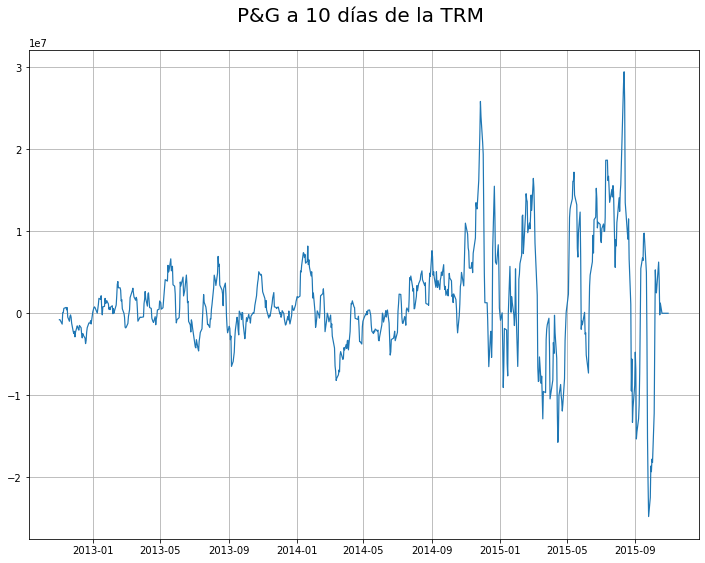

In [ ]:
PGReal = ResultadosPeriodo(datosResultado['TRM'], 10, 100*1000)
PGReal.index = datosResultado.index
plt.plot(PGReal, linewidth = 1.2)
plt.title('P&G a 10 días de la TRM \n', fontsize = 20)

plt.grid()
plt.show()

In [ ]:
def Backtesting(divisa, retornos, r, rf, k, ventanaMovil, ewma, inversionInical, dias, periodos, alpha):
  var = []
  for i in range(1, dias + 1):
    volatilidadAnual = VolatilidadPeriodo(ventanaMovil.iloc[-i], 252)
    delta = Delta(divisa.iloc[-i], 
                  rf, 1, r, k, volatilidadAnual)
    gamma = Gamma(divisa.iloc[-i], 
                    rf, 1, r, k, volatilidadAnual)
    sigma = EWMA(factorDec.x, ewma.iloc[-i], retornos.iloc[-i])
    var.append(VarCF(alpha, divisa.iloc[-i], delta, gamma, sigma)*inversionInical*sqrt(periodos))
  return pd.Series(var[::-1])


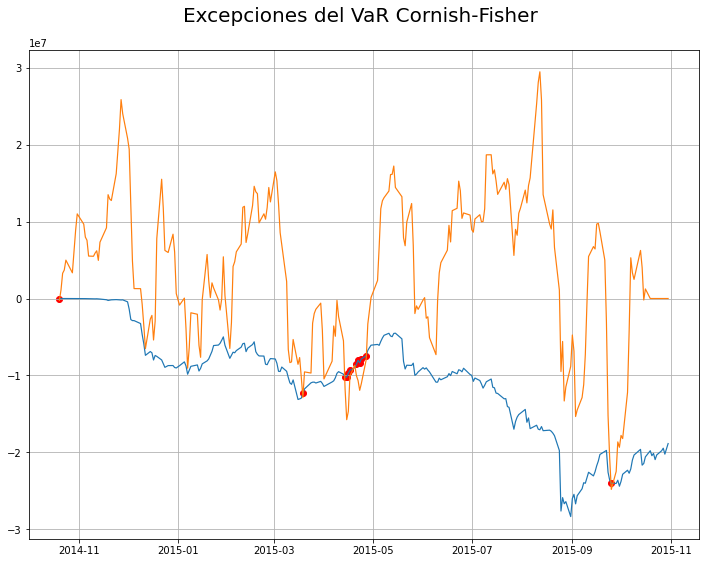

In [ ]:
backtesting = Backtesting(datosResultado['TRM'], datosResultado['Retornos TRM'], 
                          5.59/100, 0.34/100, 2700,
                          datosResultado['Pronostico VM'], datosResultado['Pronostico EWMA'],
                          100*1000, 252, 10, 0.99)
backtesting.index = datosResultado.index[-len(backtesting):]
backtesting = backtesting*-1

plt.title('Excepciones del VaR Cornish-Fisher \n', fontsize = 20)
plt.plot(backtesting, linewidth = 1.2)
plt.plot(PGReal.iloc[-len(backtesting):], linewidth = 1.2)

backtestingDF = pd.DataFrame({'Real':PGReal[-len(backtesting):-10] , 'VAR':backtesting[-len(backtesting):-10]})
backtestingDF['Excepciones'] = [backtestingDF['VAR'][i] if backtestingDF['Real'][i] < backtestingDF['VAR'][i] else np.nan for i in range(len(backtestingDF['Real']))]
backtestingDF['Excepciones'].sum()
backtestingDF

plt.scatter(backtestingDF.index, backtestingDF['Excepciones'], color ='red')
plt.grid()
plt.show()